## Aufgabe 2 : Schätzung, Test, Prognose und Prognosefehler im multivariaten Modell ##

**Verwendeter Datensatz:** https://www.kaggle.com/datasets/mirichoi0218/insurance

**Ziel:** Vorhersage von Versicherungskosten auf Basis verschiedener unabhängiger Variablen

**Allgemeines Vorgehen:**
1. Daten laden und aufbereiten
2. EDA (Vorstellung des Datensatzes)
3. Modellspezifikation
4. Modellschätzung
6. F-Test
7. Prognose (Fehler) und Prognoseintervalle
8. Test der Annahmen bivariat + (Multikollinearität, Strukturbrüche, Homoskedastizität, Autokorrelation, Normalverteilung)
9. Interpretation

In [861]:
# import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
from scipy.stats import levene
from sklearn.feature_selection import f_regression
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, recursive_olsresiduals
from scipy.stats import levene, norm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import recursive_olsresiduals

### 1. Daten laden und aufbereiten

In [862]:
# load data
insurance_data = pd.read_csv('insurance.csv')
print(insurance_data.head())
print()
print("shape: ", insurance_data.shape)

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

shape:  (1338, 7)


In [863]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [864]:
# missing data points
print('Missing data points:')
print(insurance_data.isnull().sum())

Missing data points:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [865]:
# one hot encoding
data = insurance_data.copy()
data['region'] = data['region'].map({'northeast': 1, 'northwest': 2, 'southeast': 3, 'southwest': 4})
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
data['sex'] = data['sex'].map({'female': 1, 'male': 0})
print(data.head())

## nochmal ausprobieren mit Dummy variables anstelle Label Encoding

   age  sex     bmi  children  smoker  region      charges
0   19    1  27.900         0       1       4  16884.92400
1   18    0  33.770         1       0       3   1725.55230
2   28    0  33.000         3       0       3   4449.46200
3   33    0  22.705         0       0       2  21984.47061
4   32    0  28.880         0       0       2   3866.85520


In [866]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

### 2. EDA (Vorstellung des Datensatzes)

In [867]:
# Summary statistics
data.describe().round(2)

,age,sex,bmi,children,smoker,region,charges
count,1338.00,1338.00,1338.00,1338.00,1338.0,1338.00,1338.00
mean,39.21,0.49,30.66,1.09,0.2,2.52,13270.42
std,14.05,0.50,6.10,1.21,0.4,1.10,12110.01
min,18.00,0.00,15.96,0.00,0.0,1.00,1121.87
25%,27.00,0.00,26.30,0.00,0.0,2.00,4740.29
50%,39.00,0.00,30.40,1.00,0.0,3.00,9382.03
75%,51.00,1.00,34.69,2.00,0.0,3.00,16639.91
max,64.00,1.00,53.13,5.00,1.0,4.00,63770.43


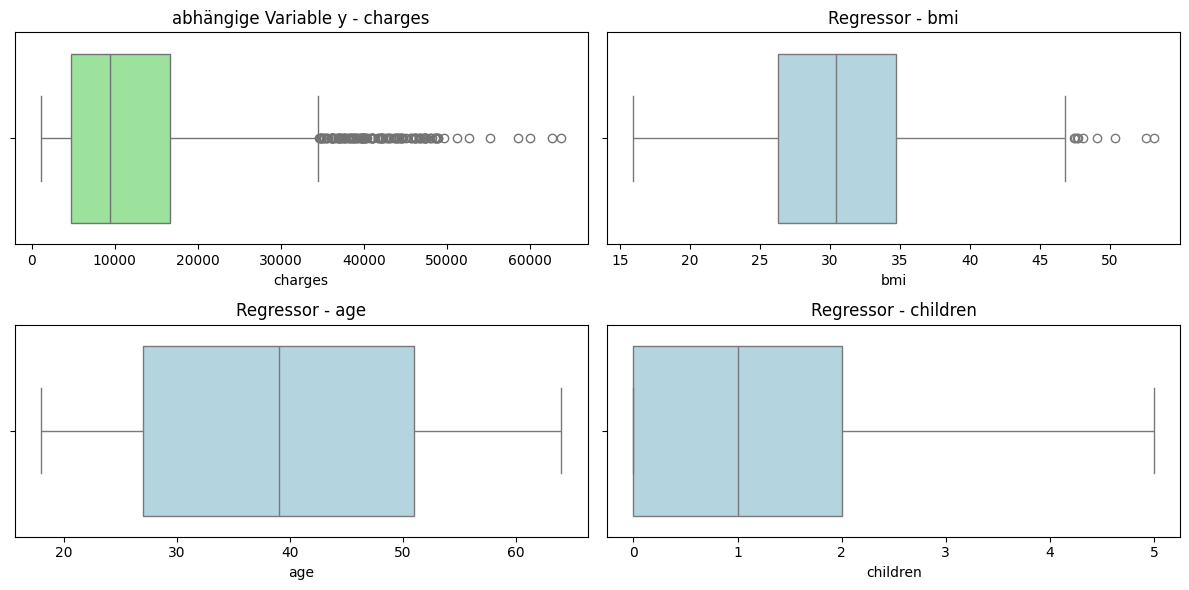

In [868]:
plt.figure(figsize=(12, 6))  

# Boxplot for 'charges'
plt.subplot(2, 2, 1)
sns.boxplot(data=data, x='charges', color='lightgreen', showfliers=True)
plt.title('abhängige Variable y - charges')

# Boxplot for 'bmi'
plt.subplot(2, 2, 2)  
sns.boxplot(data=data, x='bmi', color='lightblue')
plt.title('Regressor - bmi')

# Boxplot for 'age'
plt.subplot(2, 2, 3)  
sns.boxplot(data=data, x='age', color='lightblue')
plt.title('Regressor - age')

# Boxplot for 'children'
plt.subplot(2, 2, 4) 
sns.boxplot(data=data, x='children', color='lightblue')
plt.title('Regressor - children')

#plot
plt.tight_layout()
plt.show()

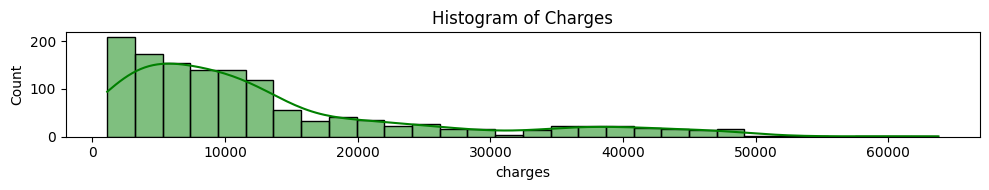

In [869]:
# Set up the plotting figure
plt.figure(figsize=(10, 2))  

# Histogram for 'charges'
sns.histplot(data['charges'], kde=True, color='green', bins=30)
plt.title('Histogram of Charges')

# Display the plot
plt.tight_layout()
plt.show()

Die unabhängige Variable Charges verteilt sich vornehmlich auf < 15-20.000 Euro.

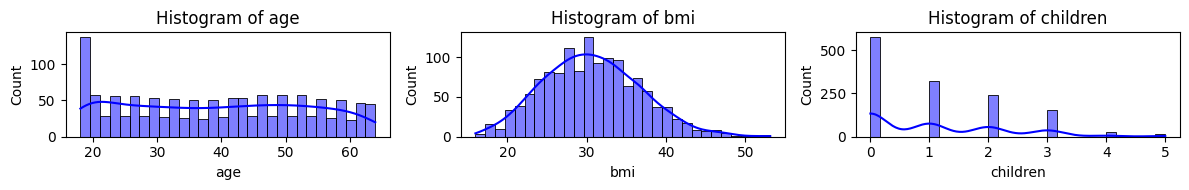

In [870]:
# Scatter plot 
plt.figure(figsize=(12, 2))  

# Histogram for 'age'
plt.subplot(1, 3, 1)  
sns.histplot(data['age'], kde=True, color='blue', bins=30)
plt.title('Histogram of age')

# Histogram for 'bmi'
plt.subplot(1, 3, 2)  
sns.histplot(data['bmi'], kde=True, color='blue', bins=30)
plt.title('Histogram of bmi')

# Histogram for 'children'
plt.subplot(1, 3, 3)  
sns.histplot(data['children'], kde=True, color='blue', bins=30)
plt.title('Histogram of children')

#plot
plt.tight_layout()
plt.show()

Auffällig ist, dass die Variable Alter eine hohe Anzahl an < 20 aufweist.


Der BMI scheint nahe Normalverteilt, mit circa 30 als Mittelwert. -> in den USA ist der durchschnittliche BMI bei circa 28. Repräsentiert damit den Durchschnitt der Bevölkerung

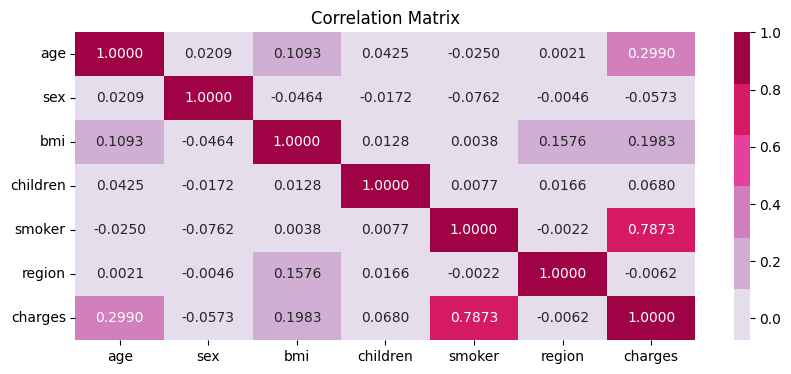

In [871]:
# Data Visualization

# Correlation Matrix
correlation_matrix = data.corr()

colormap = sns.color_palette("PuRd") 

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, cmap = colormap, annot=True, fmt=".4f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

Die Variablen, die den höchsten Korrelationswert mit der unabhängigen Variable Charges aufweisen sind:
- Smoker: 0.7873
- Age: 0.2990
- Bmi: 0.1983

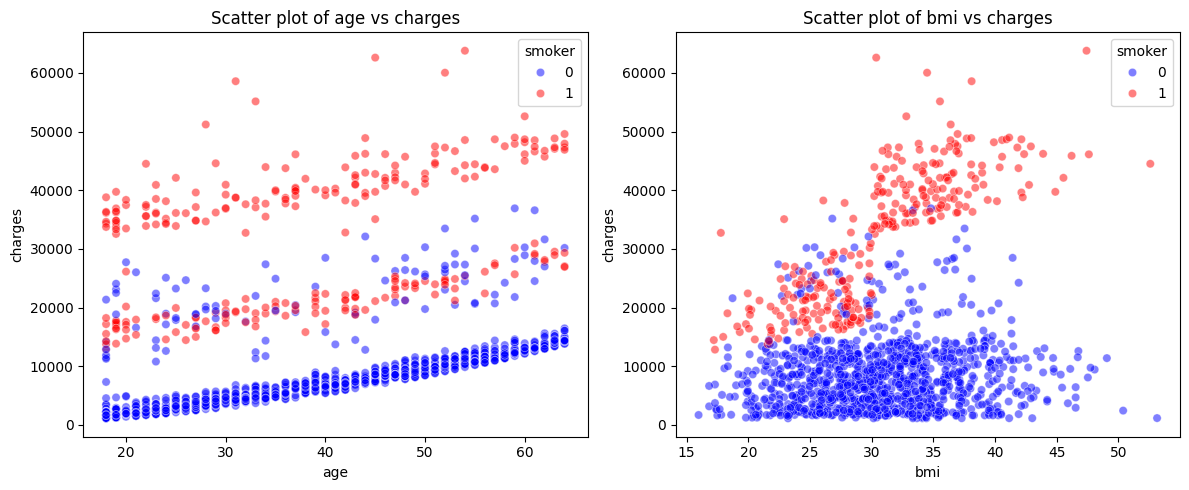

In [872]:
# Scatter plot 
plt.figure(figsize=(12, 5))  

# Scatter plot for 'charges' and 'age'
plt.subplot(1, 2, 1)  
sns.scatterplot(data=data, x='age', y='charges', hue='smoker', palette=['blue', 'red'], alpha=0.5)
plt.title('Scatter plot of age vs charges')  

# Scatter plot for 'charges' and 'bmi'
plt.subplot(1, 2, 2)  
sns.scatterplot(data=data, x='bmi', y='charges', hue='smoker', palette=['blue', 'red'], alpha=0.5)
plt.title('Scatter plot of bmi vs charges')

# Adjust layout
plt.tight_layout()
plt.show()

Der Regressor Smoker scheint einen Einfluss auf die Verteilung der Charges zu haben. Wenn Smoker 1 ist (=Raucher "Ja"), dann sind die Charges tendenziell höher, als für Smoker 0 (=Raucher "Nein"). Genauso für den BMI, der für Smoker 1 (="Raucher "Ja") tendenziell höher ist, als für Smoker 0 (=Raucher "Nein)

### 3. Modellspezifikation und 4. Modellschätzung

1. Modellspezifikation: Abhängige Variable: Charges, Unabhängige Variable: Age, Bmi, Smoker

In [873]:
# Split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(data[['age', 'bmi', 'smoker']], data['charges'], test_size=0.2, random_state=42)

# Add a constant to the feature matrix to include the intercept BETA0
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the linear regression model
lr_model = sm.OLS(y_train, X_train)
results = lr_model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     1007.
Date:                Mon, 10 Jun 2024   Prob (F-statistic):          1.65e-310
Time:                        01:19:16   Log-Likelihood:                -10851.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1066   BIC:                         2.173e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.171e+04   1061.511    -11.029      0.0

**R2= 0.739:** 73,9% der Variation in den Charges wird durch Age,BMI,Smoker erklärt

- Gibt Anteil der Varianz in der abhängigen Variable an, der durch die unabhängigen Variablen im Modell erklärt wird.

**Adjusted R2 = 0.738:** Berücksichtigt die Anzahl der erklärenden Variablen im Modell, zeigt ebenfalls einen hohen Anpassungsgrad an.

**F-Statistik = 1007:** testet die Gesamtsignifikanz des Modells
Prob F-Stat. = 0.00: deutet darauf hin, dass das Modell insgesamt signifikant ist.

- Prüft, ob die erklärenden Variablen im Modell insgesamt signifikant zur Erklärung der Variation in der abhängigen Variable beitragen.
- Vergleicht ein Modell mit erklärenden Variablen (das volle Modell) mit einem Modell ohne erklärende Variablen (das eingeschränkte Modell), um zu sehen, ob die erklärenden Variablen insgesamt signifikant sind
- Berechnet als das Verhältnis von der erklärten Varianz zur nicht erklärten Varianz

_______________________________________________________________________________________________________________________________________________________

**Log-Likelihood = -10851:** Maß für die Wahrscheinlichkeit der Daten unter dem Modell. Niedrigere Werte deuten auf eine schlechtere Anpassung hin.

- Hier negativer Wert, was typisch ist, da die Log-Likelihood in der Regel negativ ist, besonders wenn die Anzahl der Beobachtungen groß ist.
- Um zu beurteilen, wie gut dieses Modell im Vergleich zu anderen Modellen ist, betrachtet man die relative Höhe der Log-Likelihood-Werte. Ein weniger negativer Wert (z.B. -10000 im Vergleich zu -10908) würde auf eine bessere Modellanpassung hinweisen.


_______________________________________________________________________________________________________________________________________________________

**Age-coef = 259:** für jedes zusätzliche Lebensjahr steigen die "charges" im Durchschnitt um 259 Einheiten, wenn alle anderen Variablen konstant gehalten werden. 
- Der t-Wert (19.3) und der p-Wert (0.000) zeigen, dass dieser Koeffizient hoch signifikant ist.

**Bmi-coef = 326:** für jede Einheit Anstieg im BMI steigen die "charges" im Durchschnitt um 326 Einheiten, bei konstanten anderen Variablen. 
- Der t-Wert (10.4) und der p-Wert (0.000) zeigen, dass dieser Koeffizient ebenfalls signifikant ist, aber weniger stark als der für das Alter.

**Smoker-coef = 23,68:** Raucher haben im Durchschnitt 23 Einheiten mehr "charges" als Nichtraucher, bei konstanten anderen Variablen. 
- Der t-Wert (50.9) und der p-Wert (0.000) zeigen, dass dieser Koeffizient sehr hoch signifikant ist.

**Erklärung**
- Ein hoher absoluter t-Wert deutet darauf hin, dass der geschätzte Koeffizient signifikant ist -> misst, wie viele Standardabweichungen der geschätzte Koeffizient von null entfernt ist.
- Ein niedriger p-Wert (in der Regel < 0.05) deutet darauf hin, dass die Nullhypothese abgelehnt werden kann, d.h. der Koeffizient ist statistisch signifikant --> gibt die Wahrscheinlichkeit an, dass der beobachtete t-Wert (oder ein noch extremerer) unter der Nullhypothese auftritt. Die Nullhypothese besagt, dass der wahre Koeffizient null ist
_______________________________________________________________________________________________________________________________________________________


**Durbin Watson = 2.087:** testet die Autokorrelation der Residuen
- Werte um 2.0 deuten auf keine Autokorrelation hin.
- Autokorrelation bedeutet, dass die Residuen (Fehlerterme) nicht unabhängig voneinander sind, sondern in einer systematischen Weise miteinander korrelieren.

**Jarque-Bera: 611.4:** Test für die Normalverteilung der Residuen. 
- Ein hoher Wert und ein p-Wert von sehr nahe bei Null deuten auf eine signifikante Abweichung von der Normalverteilung hin.
- prüft, ob die Residuen eines Regressionsmodells einer Normalverteilung folgen.
- basiert auf den Werten für Schiefe (Skewness) und Wölbung (Kurtosis) 

- Skewness: 1.256 (positive Schiefe)
Eine positive Schiefe bedeutet, dass die Verteilung der Residuen nach rechts verschoben ist.
- Kurtosis: 5.72 (höhere Wölbung als bei einer Normalverteilung)
Eine hohe Kurtosis bedeutet, dass die Verteilung der Residuen spitzer ist als eine Normalverteilung.

- könnte bedeuten, dass das Modell möglicherweise nicht alle relevanten Variablen berücksichtigt oder dass es nicht-linearitäten oder andere Modellierungsfehler gibt.

_______________________________________________________________________________________________________________________________________________________

**Interpretation**


Signifikanz der Variablen: Alle drei erklärenden Variablen (age, bmi, smoker) sind signifikante Prädiktoren für die "charges".


Größenordnung der Effekte: Rauchen hat den stärksten Einfluss auf die "charges", gefolgt von Alter und BMI.


Modellgüte: Das Modell erklärt einen großen Teil der Variabilität der "charges" (R² = 0.73), was auf eine gute Anpassung hindeutet.


Verteilung der Residuen: Die Tests deuten darauf hin, dass die Residuen nicht normalverteilt sind, was auf mögliche Probleme mit der Modellannahme hinweist.


_______________________________________________________________________________________________________________________________________________________

In [874]:
y_pred = results.predict(X_test)
print("Predicted:")
print(y_pred[:5])
print()
print("Actual:")
print(y_test[:5])

Predicted:
764      8184.041468
887      7431.001001
890     37346.437099
1293     8629.528305
259     27316.654810
dtype: float64

Actual:
764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
Name: charges, dtype: float64


In [875]:
mse = mean_squared_error(y_test, y_pred).round(2)
print('Mean squared error for age:', mse)

mae = np.mean(np.abs(y_test - y_pred)).round(2)
print('Mean absolute error for age:', mae)

mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
print('Mean absolute percentage error for age:', mape)

Mean squared error for age: 34512843.88
Mean absolute error for age: 4260.56
Mean absolute percentage error for age: 0.5


**MAE:** zeigt, dass die vorhergesagten "charges" im Durchschnitt um etwa 4,384.57 Einheiten von den tatsächlichen Werten abweichen

**MAPE** zeigt, dass die vorhergesagten "charges" im Durchschnitt um 56% von den tatsächlichen Werten abweichen.

__________________________________________________________________________________________________________________________________________________

#### andere Modelle

Modell mit allen unabhängigen Variablen

In [876]:
# Split the dataset into train and test set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(data[['age', 'bmi', 'children', 'sex', 'smoker', 'region']], data['charges'], test_size=0.2, random_state=42)

# Add a constant to the feature matrix to include the intercept BETA0
X_train_all = sm.add_constant(X_train_all)
X_test_all = sm.add_constant(X_test_all)

# Fit the linear regression model
lr_model_all = sm.OLS(y_train_all, X_train_all)
results_all = lr_model_all.fit()

print(results_all.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     508.7
Date:                Mon, 10 Jun 2024   Prob (F-statistic):          2.71e-308
Time:                        01:19:16   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1063   BIC:                         2.174e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.169e+04   1120.252    -10.439      0.0

R2 mit 0.742 ist der höchste Wert der getesteten Modelle

- Insgesamt zeigen beide Modelle ähnliche Leistung, aber das zweite Modell (Modell 2) hat zusätzliche unabhängige Variablen, was zu einer erweiterten Modellkomplexität führt. 
- Die Wahl zwischen den Modellen könnte davon abhängen, welche Variablen theoretisch relevant sind und wie gut das Modell die Daten erklärt

In [877]:
y_pred = results_all.predict(X_test_all)

mse = mean_squared_error(y_test_all, y_pred).round(2)
print('Mean squared error for age:', mse)

mae = np.mean(np.abs(y_test_all - y_pred)).round(2)
print('Mean absolute error for age:', mae)

mape = mean_absolute_percentage_error(y_test_all, y_pred).round(2)
print('Mean absolute percentage error for age:', mape)

Mean squared error for age: 33635210.43
Mean absolute error for age: 4186.51
Mean absolute percentage error for age: 0.47


auch die weiteren Metriken zeigen, dass die Ergebnisse durch Hereinnahme aller Variablen leicht verbessert werden können

__________________________________________________________________________________________________________________________________________________

Modell mit 'age', 'bmi', 'smoker' + Children + Region

In [878]:
# Split the dataset into train and test set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data[['age', 'bmi', 'children', 'smoker', 'region']], data['charges'], test_size=0.2, random_state=42)

# Add a constant to the feature matrix to include the intercept BETA0
X_train_1 = sm.add_constant(X_train_1)
X_test_1 = sm.add_constant(X_test_1)

# Fit the linear regression model
lr_model_1 = sm.OLS(y_train_1, X_train_1)
results_1 = lr_model_1.fit()

print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     611.1
Date:                Mon, 10 Jun 2024   Prob (F-statistic):          1.04e-309
Time:                        01:19:16   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1064   BIC:                         2.173e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.168e+04   1101.811    -10.604      0.0

Genauso hoher R2, wie wenn man alle Variablen mit hinnein nimmt, aber weniger komplex

Daher Auswahl dieses Modelles

__________________________________________________________________________________________________________________________________________________

Modell mit 'age', 'bmi', 'smoker' + Geschlecht

In [879]:
# Split the dataset into train and test set
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(data[['age', 'bmi', 'smoker', 'sex']], data['charges'], test_size=0.2, random_state=42)

# Add a constant to the feature matrix to include the intercept BETA0
X_train_s = sm.add_constant(X_train_s)
X_test_s = sm.add_constant(X_test_s)

# Fit the linear regression model
lr_model_s = sm.OLS(y_train_s, X_train_s)
results_s = lr_model_s.fit()

print(results_s.summary())

#Ergebnis der 3 Varibalen + Geschlecht: R²-Wert bei 0.74
#schlechter als primär Modell (0.87)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     754.8
Date:                Mon, 10 Jun 2024   Prob (F-statistic):          5.68e-309
Time:                        01:19:16   Log-Likelihood:                -10851.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1065   BIC:                         2.174e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.17e+04   1081.194    -10.824      0.0

__________________________________________________________________________________________________________________________________________________

Modell mit 'age', 'bmi', 'smoker_yes' + Regionen

In [880]:
# Split the dataset into train and test set
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(data[['age', 'bmi', 'smoker', 'region']], data['charges'], test_size=0.2, random_state=42)

# Add a constant to the feature matrix to include the intercept BETA0
X_train_r = sm.add_constant(X_train_r)
X_test_r = sm.add_constant(X_test_r)

# Fit the linear regression model
lr_model_r = sm.OLS(y_train_r, X_train_r)
results_r = lr_model_r.fit()

print(results_r.summary())

#Ergebnis der 3 Varibalen + Regionen: R²-Wert bei 0.74
#schlechter als primär Modell (0.87)

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     757.3
Date:                Mon, 10 Jun 2024   Prob (F-statistic):          1.55e-309
Time:                        01:19:16   Log-Likelihood:                -10849.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1065   BIC:                         2.173e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.127e+04   1094.876    -10.294      0.0

____

von hier an Modellauswahl, des Modells AGE, BMI, SMOKER, CHILDREN, REGION

Das Modell hat eine ähnliche Leistung wie die anderen Modelle aber leicht höherer R2 mit weniger Variablen

Die Änderungen in den Koeffizienten für "children" und "region" sind geringfügig und könnten auf verschiedene Datenpunkte oder Modellierungsentscheidungen zurückzuführen sein.

Insgesamt scheint das neue Modell eine angemessene Erklärung der Variation in den Krankenversicherungskosten zu bieten, aber die Nichtnormalität der Residuen bleibt ein potenzielles Problem, das weiter untersucht werden sollte.

__________________________________________________________________________________________________________________________________________________

### 5. F-Test

- **Hypothesen**:
  - **H₀**: Alle Gruppenmittelwerte sind gleich.
  - **H₁**: Mindestens ein Gruppenmittelwert unterscheidet sich.

- **F-Statistik**:
  - F = (MS_between) / (MS_within)
  - MS_between: Varianz zwischen den Gruppen.
  - MS_within: Varianz innerhalb der Gruppen.





Ergebnis siehe oben -> hier Berechnung per Hand

In [881]:
### 6. F-Test

import numpy as np

# Werte aus dem Modell
R_squared_model = 0.742
num_predictors = 5
num_observations = 1070

# Nullmodell-R-squared (angenommen)
R_squared_null = 0.0  # Annahme eines Nullmodells ohne Vorhersagekraft

# Berechnung der F-Statistik
F_statistic = ((R_squared_model - R_squared_null) / num_predictors) / ((1 - R_squared_model) / (num_observations - num_predictors - 1))

print("F-Statistik:", F_statistic)


F-Statistik: 612.0062015503876


### 7. Prognose (Fehler) und Prognoseintervalle

In [882]:
# Calculate forecast errors
prediction_errors = results.resid

# Calculate prediction intervals
pred_ci = results.get_prediction().conf_int()

# Extract lower and upper bounds of the prediction intervals
lower_bounds = pred_ci[:, 0]
upper_bounds = pred_ci[:, 1]

# Take predictions of the same length as the other arrays
y_pred = results.predict()

# Create DataFrame
data_dict = {
    "Predictions": y_pred,
    "Lower Bound": lower_bounds,
    "Upper Bound": upper_bounds,
    "Prediction Errors": prediction_errors
}

df = pd.DataFrame(data_dict)
df


,Predictions,Lower Bound,Upper Bound,Prediction Errors
560,6737.749210,5931.261001,7544.237418,2456.089290
1285,8423.746929,7812.875525,9034.618333,110.924871
1142,9897.081077,9244.029410,10550.132744,17220.912703
969,9612.967613,9137.934902,10088.000325,-1016.139813
486,9309.235199,8486.881229,10131.589170,3166.116101
...,...,...,...,...
1095,3195.796127,2481.811682,3909.780571,1365.392373
1130,6201.562687,5619.078404,6784.046970,2380.739613
1294,11556.374128,10813.255075,12299.493181,374.751122
860,37104.778134,35774.308520,38435.247747,9008.732866


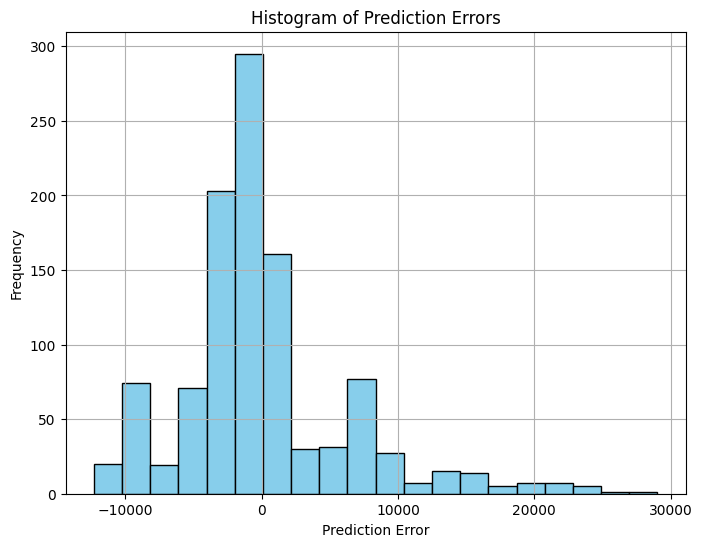

In [883]:
import matplotlib.pyplot as plt

# Plot histogram of prediction errors
plt.figure(figsize=(8, 6))
plt.hist(prediction_errors, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.grid(True)
plt.show()


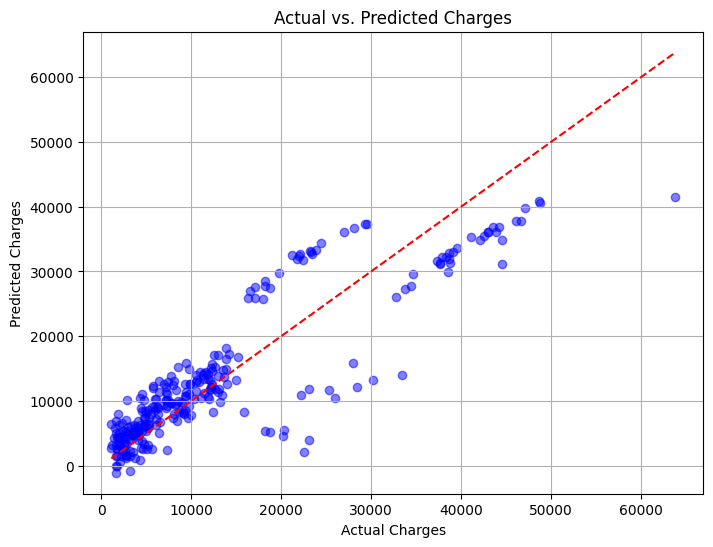

In [884]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = results.predict(X_test)

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Charges')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.grid(True)
plt.show()

### 8. Test der Annahmen (Multikollinearität, Strukturbrüche, Heteroskedastizität, Autokorrelation, Normalverteilung)

In [885]:
# ab hier ohne Konstante gerechnet

# Split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(data[['age', 'bmi', 'smoker']], data['charges'], test_size=0.2, random_state=42)


# Fit the linear regression model
lr_model = sm.OLS(y_train, X_train)
results = lr_model.fit()

y_pred = results.predict(X_test)

  feature       VIF
0     age  7.558811
1     bmi  7.823602
2  smoker  1.245937


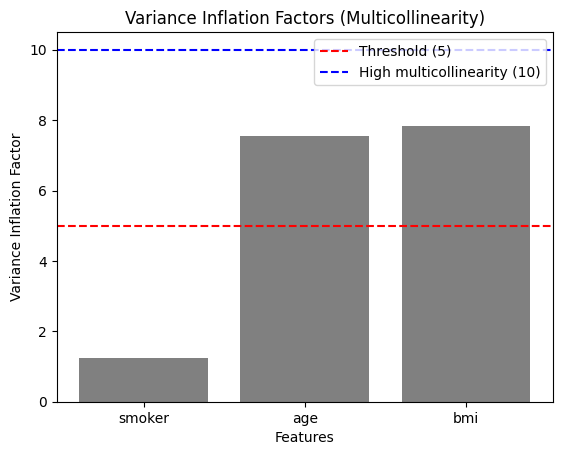

In [886]:
# Berechnung des Variance Inflation Factors (VIF)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data)

# Plotting
fig, ax = plt.subplots()
vif_data.sort_values('VIF', inplace=True)
ax.bar(vif_data['feature'], vif_data['VIF'], color='grey')
ax.set_xlabel('Features')
ax.set_ylabel('Variance Inflation Factor')
ax.set_title('Variance Inflation Factors (Multicollinearity)')
ax.axhline(5, color='red', linestyle='--', label='Threshold (5)')
ax.axhline(10, color='blue', linestyle='--', label='High multicollinearity (10)')
ax.legend()

plt.show()

**Interpretation:**

Die VIF-Werte geben Auskunft über das Ausmaß der Multikollinearität, also ob die Regressoren miteinander korrellieren. 
- **Beispiel für Multikollinearität:** x1: Einkommen, x2: Konsum --> Typischerweise je höher Einkommen, desto höher Konsum

**Schwellwerte:**

- **VIF > 5:**    Zeichen für moderat hohe Multikollinearität, die möglicherweise problematisch ist.
- **VIF > 10:**   Zeichen für hohe Multikollinearität, die die Genauigkeit der Regressionskoeffizienten beeinträchtigen kann.

**VIF-Werte:**

- **smoker_yes:** VIF = 1,25 zeigt, dass Variable wenig Anzeichen von Multikollinearität aufweist. D.h. smoker_yes ist unabhängig von 'age' und 'bmi' und lässt sich nicht durch die anderen Variablen im Modell erklären.
- **age:** VIF = 7,65 zeigt, dass Variable moderate bis hohe Anzeichen von Multikollinearität aufweist. D.h. dass age teilweise durch andere Variable im Mdell beeinflusst wird, möglicherweise bmi (...je höher bmi, desto höher age)
- **bmi:** VIF = 7.83 --> analog age 

**Fazit:**
Die relativ hohen VIF-Werte für age und bmi legen nahe, dass diese Variablen möglicherweise miteinander korreliert sind.

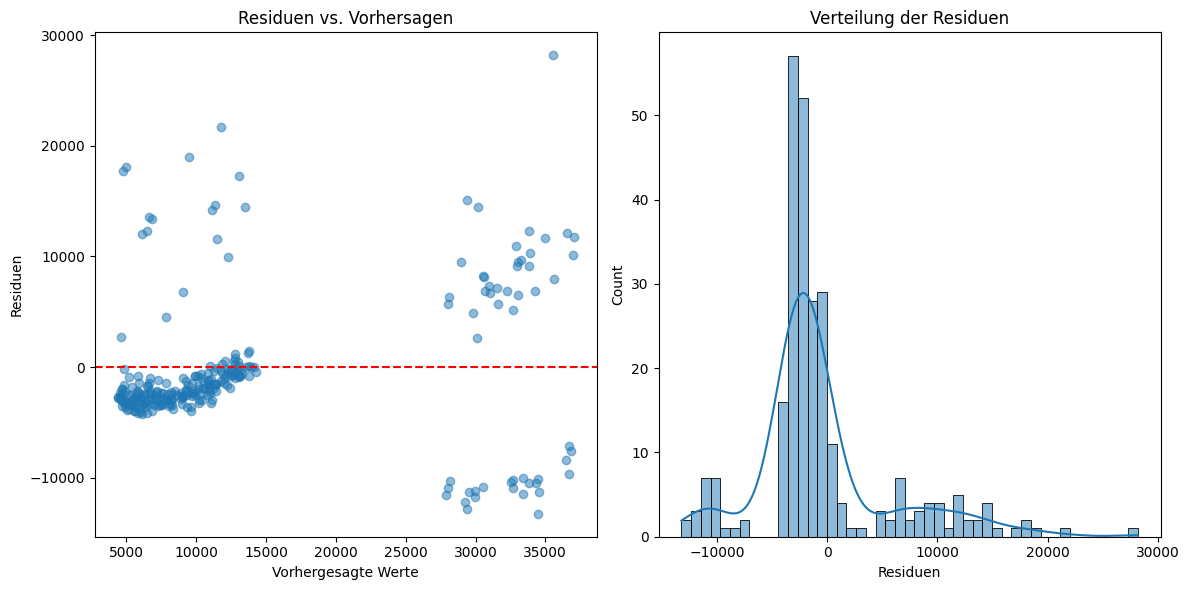

In [887]:
# Berechnen der Residuen
residuals = y_test - y_pred

# Residuen vs. Vorhersagen
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Residuen')
plt.title('Residuen vs. Vorhersagen')

# Residuenverteilung
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuen')
plt.title('Verteilung der Residuen')

plt.tight_layout()
plt.show()

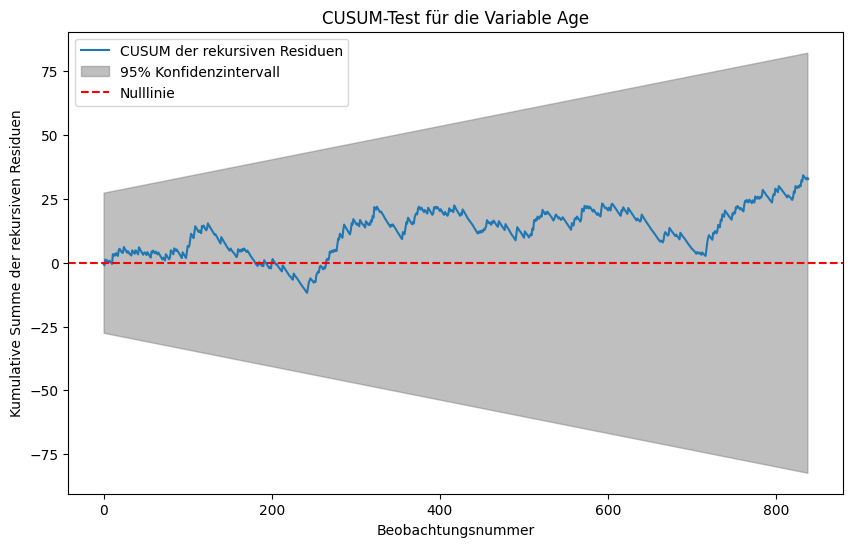

In [888]:
# Daten laden 
data = insurance_data.copy()

# Daten nach 'age' sortieren
data_sorted = data.sort_values(by='age')

# Daten vorbereiten
X = sm.add_constant(data_sorted['age'])  # Unabhängige Variable 'age' mit Konstante
y = data_sorted['charges']  # Abhängige Variable

# OLS-Modell für 'age'
model = sm.OLS(y, X).fit()

# Rekursive Residuen extrahieren
(resid, params, rypred, resid_standardized, resid_scaled, rcusum, rcusumci) = recursive_olsresiduals(model, skip=500)


# CUSUM-Plot der rekursiven Residuen
plt.figure(figsize=(10, 6))
plt.plot(rcusum, label='CUSUM der rekursiven Residuen')

# Angepasste x-Werte für Konfidenzintervalle
x_values = range(len(rcusum) - 1)  # Reduziere die Länge um eins, um Übereinstimmung zu erzielen

plt.fill_between(x_values, rcusumci[0, :], rcusumci[1, :], color='gray', alpha=0.5, label='95% Konfidenzintervall')
plt.axhline(y=0, color='r', linestyle='--', label='Nulllinie')
plt.title('CUSUM-Test für die Variable Age')
plt.xlabel('Beobachtungsnummer')
plt.ylabel('Kumulative Summe der rekursiven Residuen')
plt.legend()
plt.show()



**Anwendung/Funktionsweise CUSUM-Test:**

- Daten nach Alter ('age') sortieren 
- 'X': sortiertes Alter + Konstante 
- 'y': sortierte 'charges'
- lineares Modell schätzen 

- Y = β0 +β1 X1 (Geschätzt basierend auf den ersten 500 Beobachtungen)
- Rekursive Residuen: Differenzen zwischen den beobachteten Werten und den durch das Modell vorhergesagten Werten, berechnet nach jeder neuen Beobachtung, wobei das Modell jedes Mal neu angepasst wird.

**Interpretation:**

- Im Plot werden die kumulativen Residuen gezeigt
- Die Nulllinie stellt keine Abweichung dar; die graue Fläche repräsentiert das 95% Konfidenzintervall
- Wenn die CUSUM-Linie (Blaue Linie) systematisch und signifikant aus diesem Bereich herausfällt, deutet dies auf potenzielle Strukturbrüche hin.
- Die CUSUM-Linie bleibt weitgehend innerhalb des Konfidenzintervalls, was darauf hindeutet, dass keine signifikanten Strukturbrüche im Modell vorhanden sind.

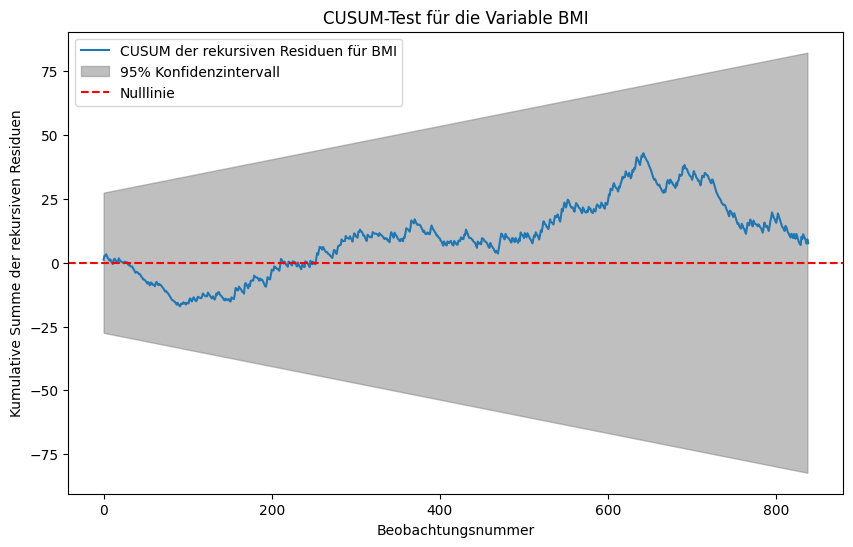

In [889]:
# Daten nach 'bmi' sortieren
data_sorted_bmi = data.sort_values(by='bmi')

# Daten für das Modell vorbereiten
X_bmi = sm.add_constant(data_sorted_bmi['bmi'])  # Unabhängige Variable 'bmi' mit Konstante
y_bmi = data_sorted_bmi['charges']  # Abhängige Variable

# OLS-Modell für 'bmi'
model_bmi = sm.OLS(y_bmi, X_bmi).fit()

# Rekursive Residuen für das BMI-Modell extrahieren
resid_bmi, params_bmi, rypred_bmi, resid_standardized_bmi, resid_scaled_bmi, rcusum_bmi, rcusumci_bmi = recursive_olsresiduals(model_bmi, skip=500)

# CUSUM-Plot für die Variable BMI
plt.figure(figsize=(10, 6))
plt.plot(rcusum_bmi, label='CUSUM der rekursiven Residuen für BMI')

# Angepasste x-Werte für Konfidenzintervalle bei BMI
x_values_bmi = range(len(rcusum_bmi) - 1)  # Reduziere die Länge um eins, um Übereinstimmung zu erzielen

plt.fill_between(x_values_bmi, rcusumci_bmi[0, :], rcusumci_bmi[1, :], color='gray', alpha=0.5, label='95% Konfidenzintervall')
plt.axhline(y=0, color='red', linestyle='--', label='Nulllinie')
plt.title('CUSUM-Test für die Variable BMI')
plt.xlabel('Beobachtungsnummer')
plt.ylabel('Kumulative Summe der rekursiven Residuen')
plt.legend()
plt.show()


**Interpretation:**
- einige signifikante Schwankungen sind vorhanden, insbesondere einen deutlichen Anstieg in der Mitte der Beobachtungsreihe (steigender BMI), gefolgt von einem Abfall.
- Die meiste Zeit bleibt der CUSUM innerhalb des 95% Konfidenzintervalls, d.h. die meisten Änderungen im Modell liegen innerhalb des erwarteten Variationsbereichs und zeigen keine dauerhaften Strukturbrüche auf.

In [890]:
# Residuen basierend auf einem Kriterium in zwei Gruppen teilen --> Kriterium: Median der vorhergesagten Werte
median_pred = np.median(y_pred)
low_pred_resid = residuals[y_pred <= median_pred]
high_pred_resid = residuals[y_pred > median_pred]

# Levene-Test auf Homoskedastizität der geteilten Residuen
statistic_levene, pvalue_levene = levene(low_pred_resid, high_pred_resid)

# Goldfeld-Quandt-Test
statistic_gq, pvalue_gq, _ = het_goldfeldquandt(residuals, X_test)

# Ergebnisse ausgeben
results_table = pd.DataFrame({
    "Test": ["Levene-Test", "Goldfeld-Quandt-Test"],
    "Teststatistik": [f"{statistic_levene:.2f}", f"{statistic_gq:.2f}"],
    "p-Value": [f"{pvalue_levene:.3f}", f"{pvalue_gq:.3f}"],
    "Ergebnis": ["keine Heteroskedastizität" if p > 0.05 else "Heteroskedastizität" for p in [pvalue_levene, pvalue_gq]]
})

print(results_table)


# Goldfeld-Qandt-Test evtl. von Hand nochmal prüfen


                   Test Teststatistik p-Value                   Ergebnis
0           Levene-Test         36.68   0.000        Heteroskedastizität
1  Goldfeld-Quandt-Test          1.01   0.473  keine Heteroskedastizität


**grafische Interpretation:**

- **Residuen vs Vorhersage:** Streuung der Residuen steigt mit wachsenden Charges. Dies deutet auf Heteroskedastizität hin, d.h. die Varianz der Fehlerterme ist nicht konstant, sondern variiert mit dem Level (...steigend) der vorhergesagten Werte.

Das deutliche Auffächern der Residuen bei höheren vorhergesagten Werten ist ein Zeichen von Heteroskedastizität. Daher weitere Analyse, ob die Varianz der Residuen wirklich nicht konstant ist mittels F-Test/Goldfeld-Qandt-Test:

- **H0:**                           σ1^2 = σ2^2 (Varianz ist in beiden Gruppen gleich --> Homoskedatizität)
- **H1 (F-Test):**                  σ1^2 =/= σ2^2 (Varianz ist unterschiedlich --> Heteroskedastizität)
- **H1 (Goldfeld-Quandt-Test):**    σ1^2 < σ2^2 (Varianz in Gruppe 1 ist kleiner als in Gruppe 2 --> Heteroskedastizität)

**Fazit:**
- Levene-Test: Deutliche Heteroskedastizität, d.h. die Varianz der Residuen ändert sich mit den vorhergesagten Werten.
- Goldfeld-Quandt-Test: Keine signifikante Heteroskedastizität --> unterschiedliche Empfindlichkeiten der Tests? evtl- fehlerhaft abgebildet


In [891]:
dw_stat = durbin_watson(residuals)
print(f"dw = {dw_stat:.3f}")

dw = 2.092


**grafische Interpretation:**

- Es gibt keine klaren zyklischen Muster in der Verteilung der Residuen gegenüber den vorhergesagten Werten, was gegen eine starke Autokorrelation spricht.

**Weitere Überprüfung durch Durbin Watson Test:**

- H0 : ρ1 =0
- Die Nullhypothese besagt, dass es keine Autokorrelation erster Ordnung gibt, d.h., die aufeinanderfolgenden Residuen sind nicht miteinander korreliert.

- Der Test ergibt eine Durbin-Watson-Statistik von DW = 2,092, also einen Wert nahe 2, was auf die Abwesenheit von Autokorrelation hin deutet.

In [892]:

# Perform Jarque-Bera test
jb_statistic, jb_p_value = jarque_bera(residuals)
print(f"Jarque-Bera statistic: {jb_statistic}")
print(f"P-value of the Jarque-Bera test: {jb_p_value}")

Jarque-Bera statistic: 170.41865024712388
P-value of the Jarque-Bera test: 9.86416418123225e-38


**grafische Interpretation:**

- Die blaue Kurve (Verteilung der Residuen --> Normalverteilung) passt gut über das Histogramm, was darauf hindeutet, dass die Residuen annähernd normalverteilt sind.

**Jarque-Bera Test:**

- Die Teststatistik ist sehr hoch, was darauf hindeutet, dass die Residuen signifikante Abweichungen von einer Normalverteilung aufweisen.
- Der P-Wert ist sehr niedrig (...fast 0), weit unter einem üblichen Signifikanzniveau (z.B. 0.01, 0.05). Dies bedeutet, dass wir die Nullhypothese, dass die Residuen normalverteilt sind, ablehnen können.




